### Import

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from evaluation import *
from data_loader import *
import random
from datetime import datetime

### Get Config
Note that the below cell fetches all of the config data which is also used to train the models. This code will not run if you have not already completed a training simulation at some point with the same config parameters. If you have run the training already, you can set the `train_model` parameter in the `evaluation_congfig.yaml` file to `False` so that you can get the results without having to run the training again.

In [2]:
config_fname = 'config.yaml'

c = load_config_file(config_fname)
nn_c = c['nn_hyperparameters']
federated_c = c['federated_learning_settings']
algo_c = c['algorithm_settings']
env_c = c['environment_settings']
eval_c = c['eval_config']

verbose = eval_c['verbose']

if eval_c['fixed_attributes'] != [0, 1] and eval_c['fixed_attributes'] != [1, 0] and eval_c['fixed_attributes'] != [0.5, 0.5]:
    attr_label = 'learned'
else:
    fixed_attributes = eval_c['fixed_attributes']
    attr_label = f'{fixed_attributes[0]}_{fixed_attributes[1]}'

current_datetime = datetime.now()
date = current_datetime.strftime('%Y-%m-%d_%H-%M')

### Get EV Info

In [3]:
ev_info = []

seed = env_c['seed']

# Assign seed
random.seed(seed)
# Creating and seeding a random generaton from Numpy
rng = np.random.default_rng(seed)

for _ in env_c['coords']:
    # Generate a random model index for each agent
    model_indices = np.array([random.randrange(3) for agent in range(env_c['num_of_cars'])], dtype=int)

    # Use the indices to select the model type and corresponding configurations
    model_type = np.array([env_c['models'][index] for index in model_indices], dtype=str)
    usage_per_hour = np.array([env_c['usage_per_hour'][index] for index in model_indices], dtype=int)
    max_charge = np.array([env_c['max_charge'][index] for index in model_indices], dtype=int)

    start_time = time.time()
    # Random charge between 0.5-x%, where x scales between 1-25% as sessions continue
    starting_charge = env_c['starting_charge'] + 2000*(rng.random(env_c['num_of_cars'])-0.5)
    elapsed_time = time.time() - start_time

    # Define a structured array
    dtypes = [('starting_charge', float),
                ('max_charge', int),
                ('usage_per_hour', int),
                ('model_type', 'U50'),  # Adjust string length as needed
                ('model_indices', int)]
    info = np.zeros(env_c['num_of_cars'], dtype=dtypes)

    # Assign values
    info['starting_charge'] = starting_charge
    info['max_charge'] = max_charge
    info['usage_per_hour'] = usage_per_hour
    info['model_type'] = model_type
    info['model_indices'] = model_indices

    ev_info.append(info)

### Load Metrics

In [4]:
algorithm_dm = algo_c['algorithm']

experiment_path = os.getcwd()
experiment_number = os.path.basename(experiment_path).split()[-1]

def load_from_json_with_error_handling(filepath):
    try:
        return read_csv_data(filepath)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from {filepath}: {e.msg} at line {e.lineno}, column {e.colno}")
        return None  # Handle the error and return None or an empty object

#d_base = f"../../../../../storage_1/metrics/{experiment_number}"
d_base = f"../../metrics/{experiment_number}"
        
base_path = f"{d_base}/train/metrics"

# Load each JSON file with error handling
agent_data = load_from_json_with_error_handling(f'{base_path}_agent_metrics.csv')
station_data = load_from_json_with_error_handling(f'{base_path}_station_metrics.csv')

### Routes of Last Episode

KeyError: 'path'

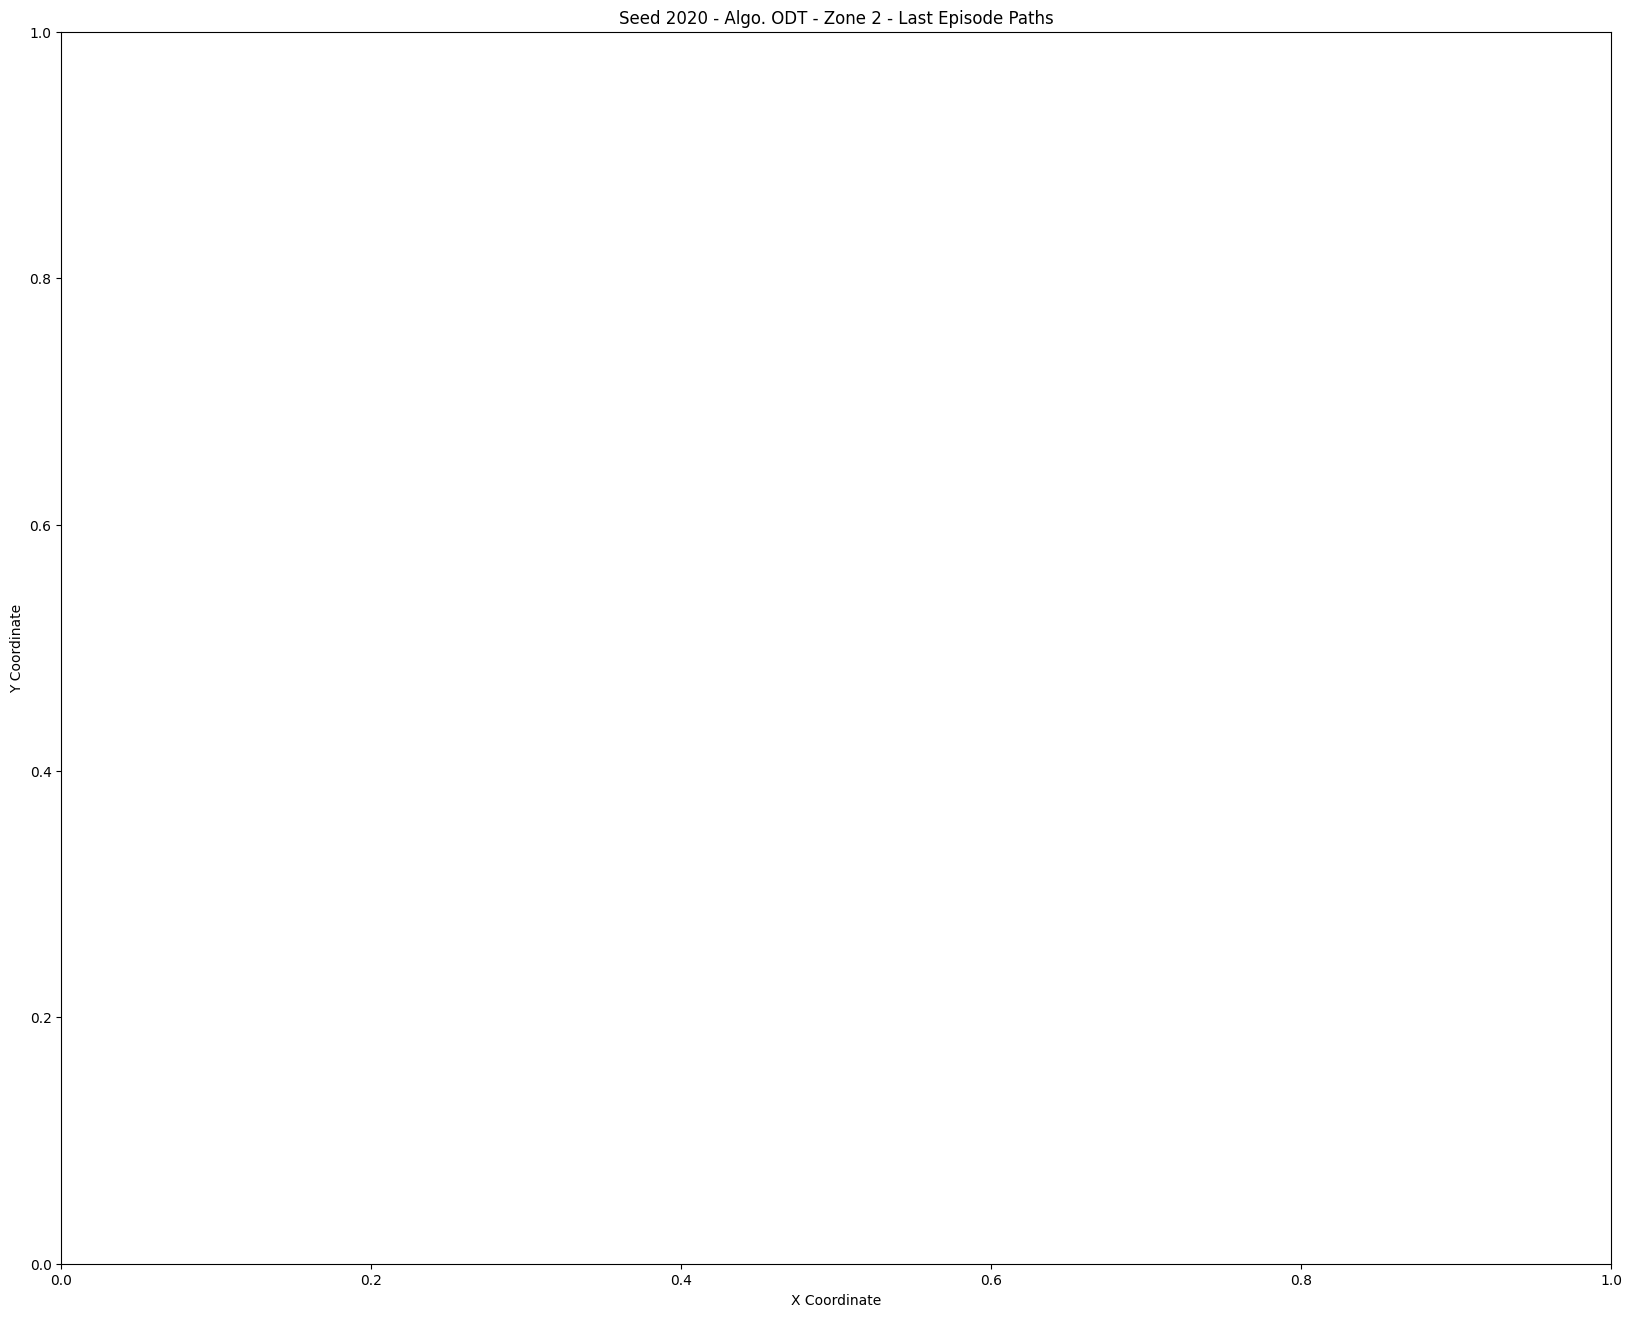

In [5]:
from evaluation import draw_map_of_last_episode
draw_map_of_last_episode(agent_data, seed, algorithm_dm)

### Distance Metrics

Evaluating Distance Travelled (km) Metrics for seed 2020


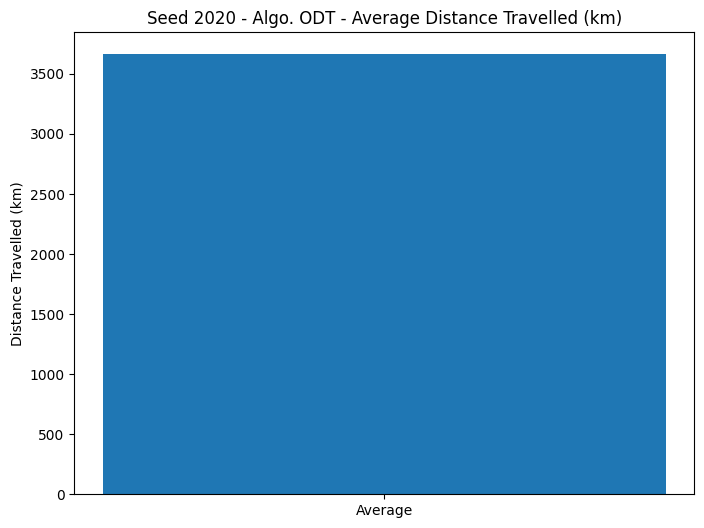

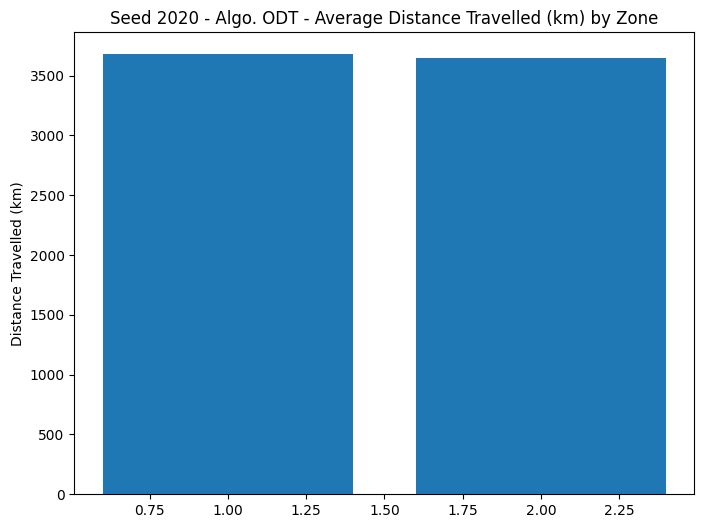

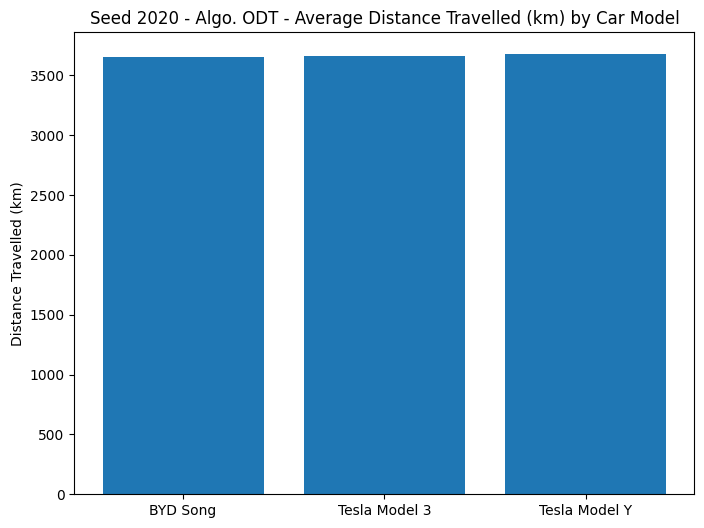

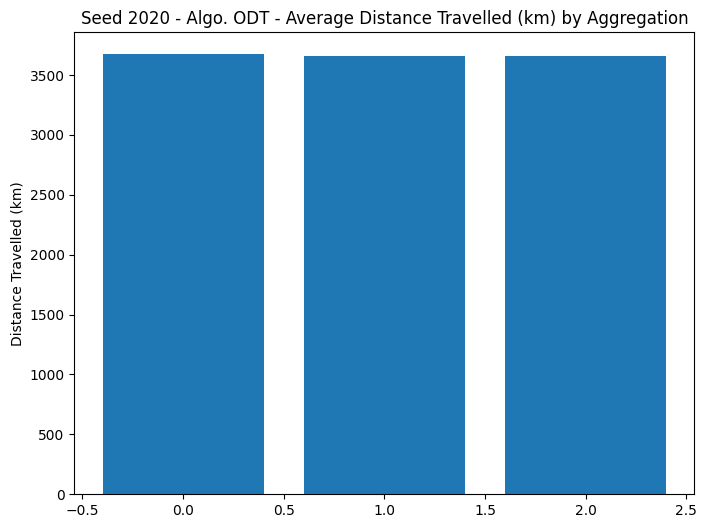

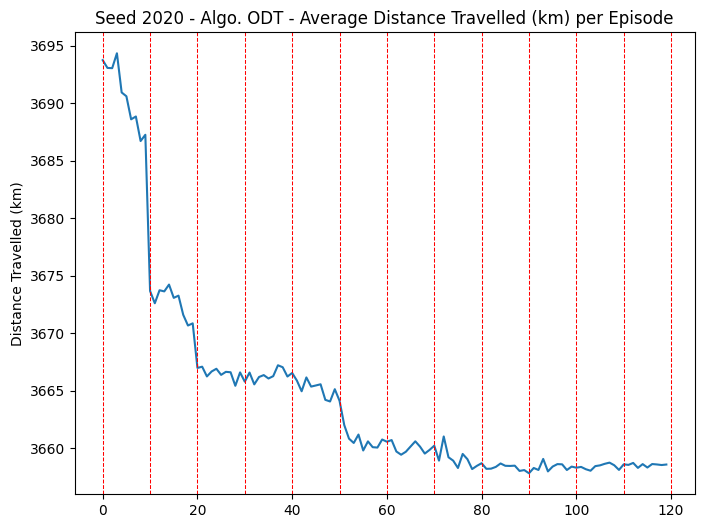

<Figure size 800x600 with 0 Axes>

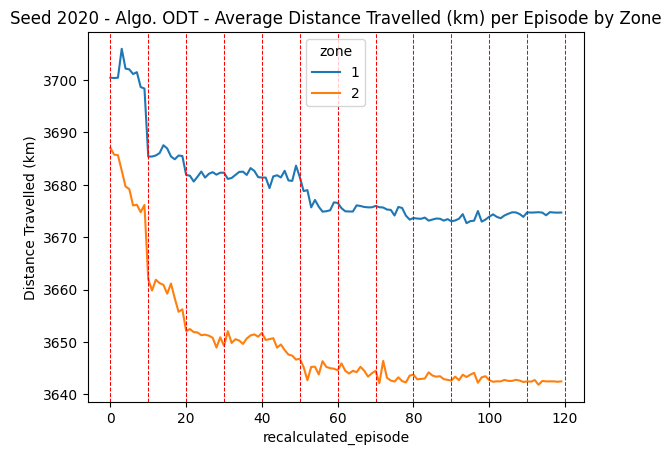

<Figure size 800x600 with 0 Axes>

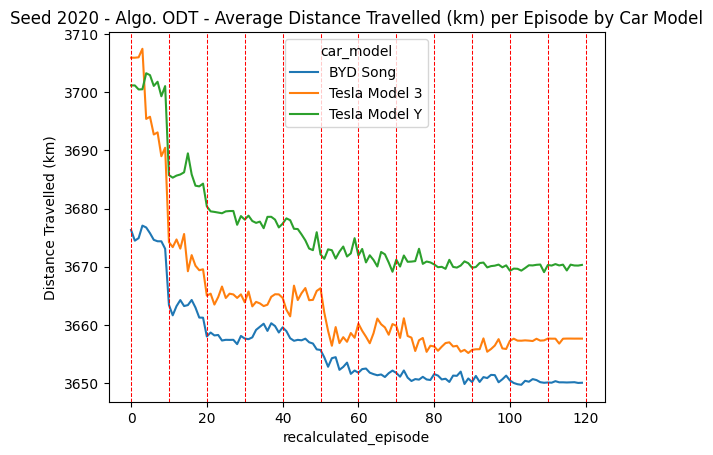

<Figure size 800x600 with 0 Axes>

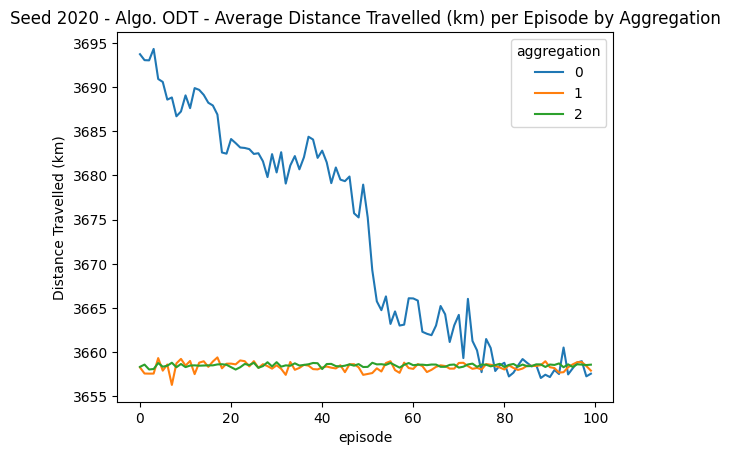

In [6]:
### Distance Metrics
evaluate_by_agent(agent_data, 'distance', 'Distance Travelled (km)', seed, verbose, nn_c['num_episodes'], algorithm_dm)

### Average Battery Metrics

Evaluating Battery Level (Watts) Metrics for seed 2020


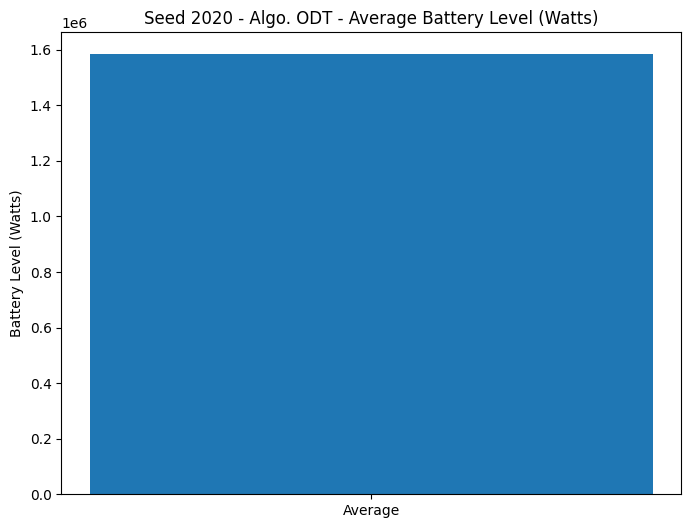

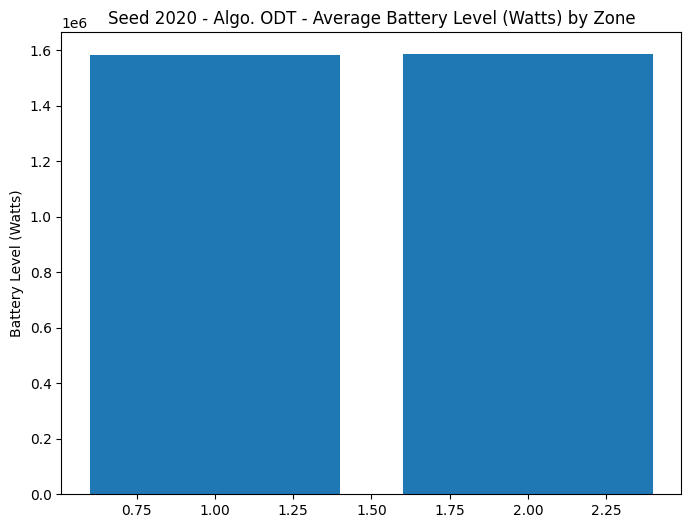

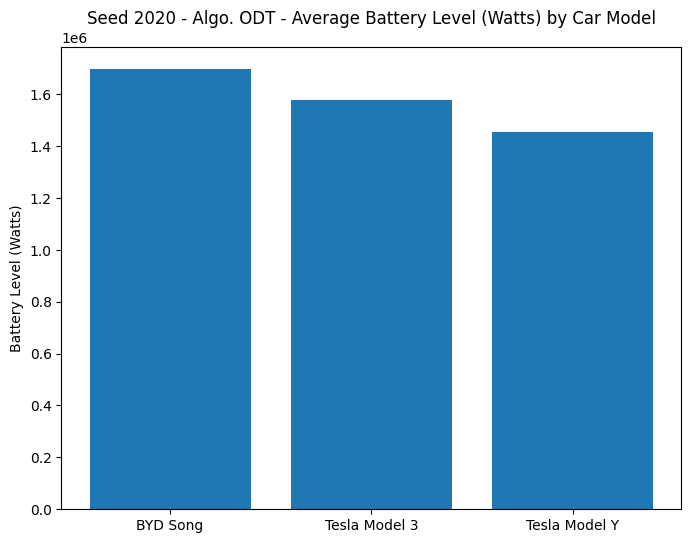

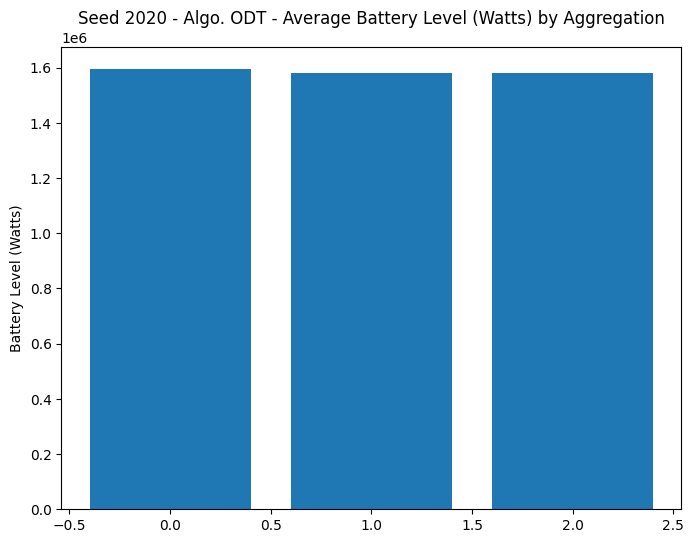

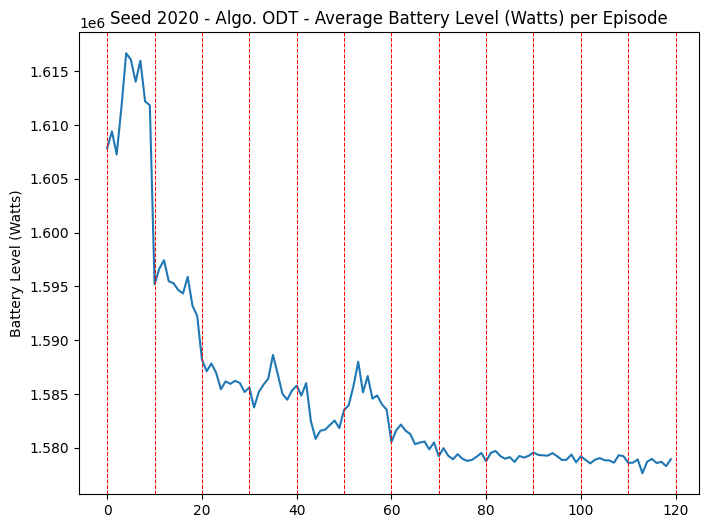

<Figure size 800x600 with 0 Axes>

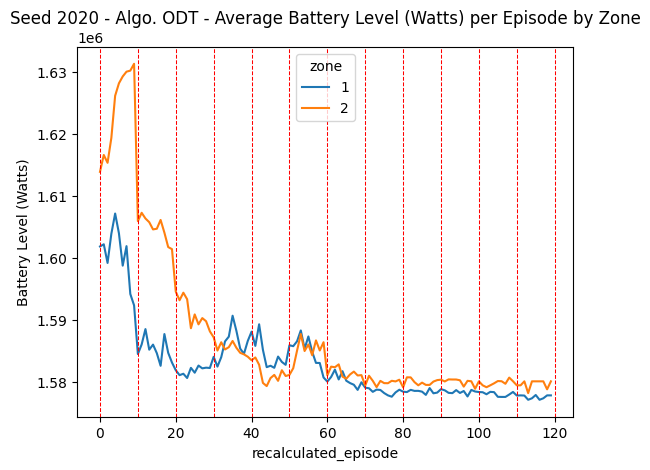

<Figure size 800x600 with 0 Axes>

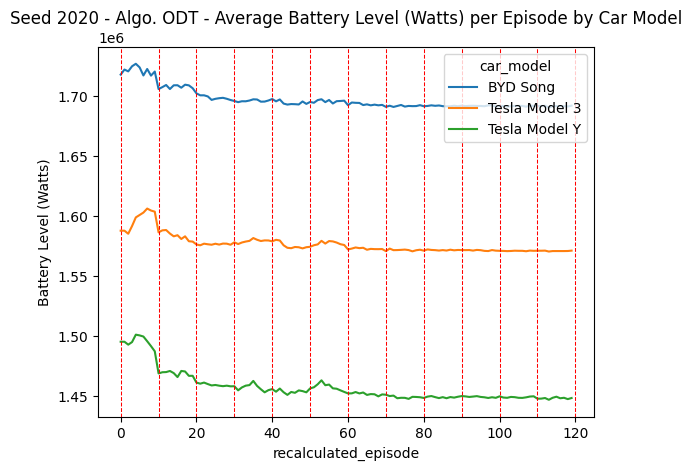

<Figure size 800x600 with 0 Axes>

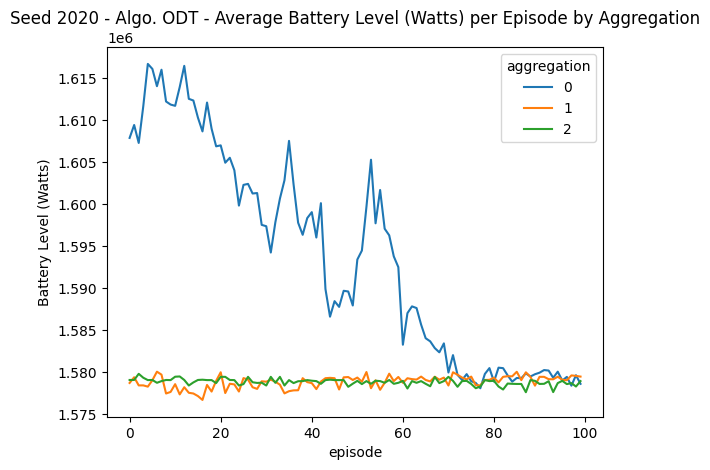

In [7]:
### Average Battery Metrics
evaluate_by_agent(agent_data, 'average_battery', 'Battery Level (Watts)', seed, verbose, nn_c['num_episodes'], algorithm_dm)

### Ending Battery Metrics

Evaluating Ending Battery Level (Watts) Metrics for seed 2020


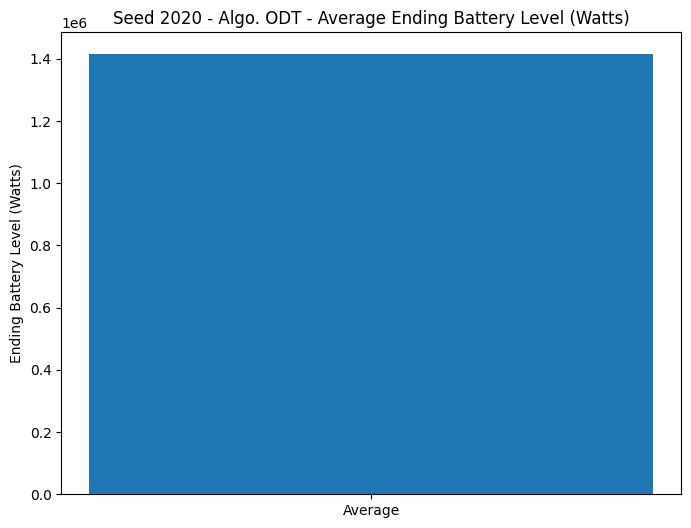

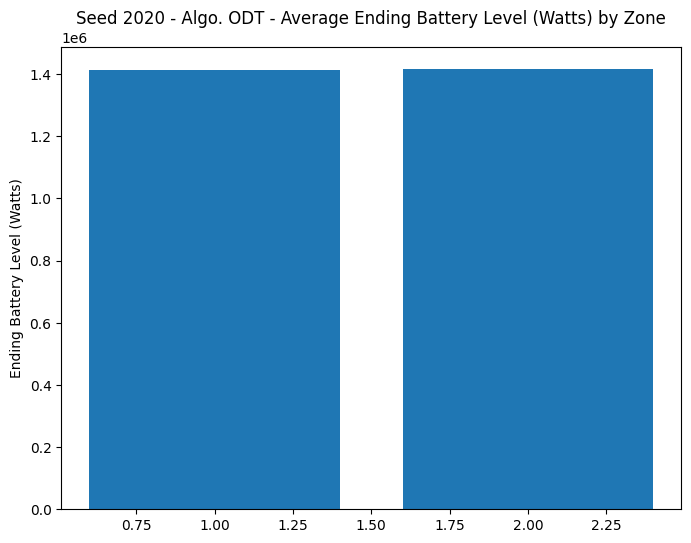

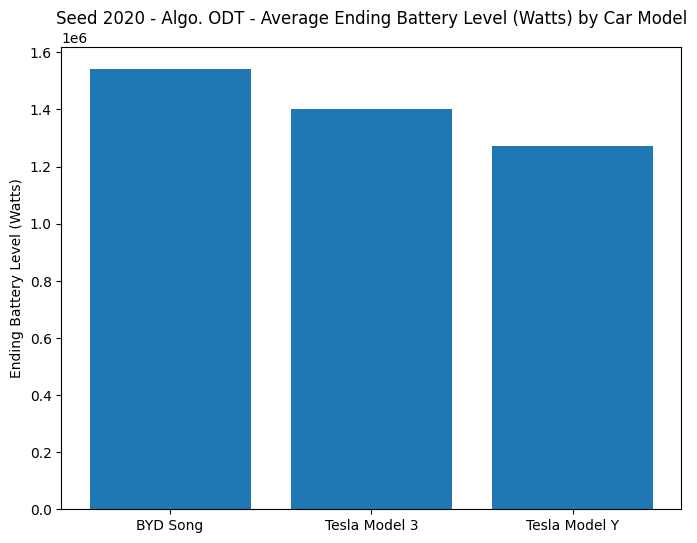

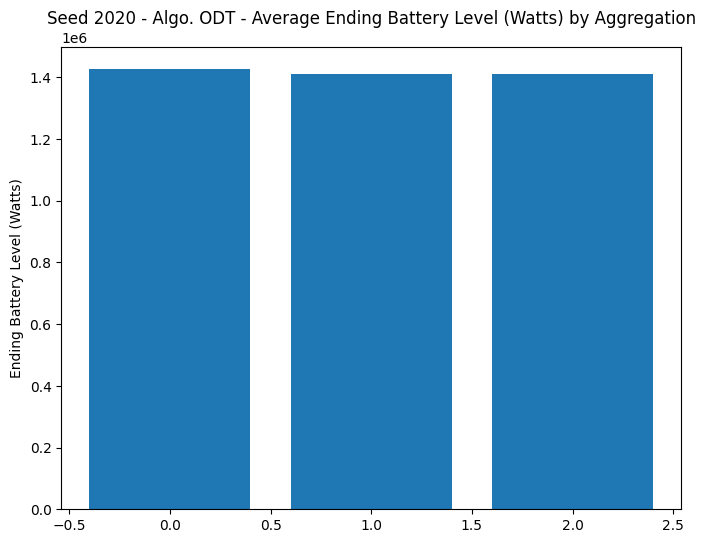

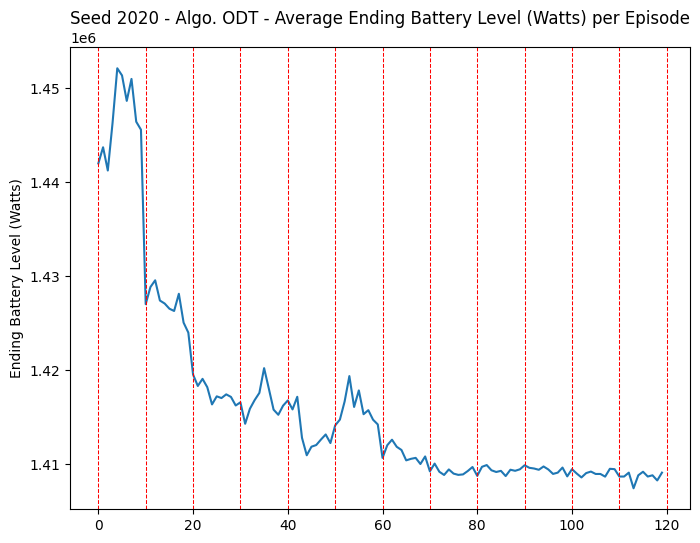

<Figure size 800x600 with 0 Axes>

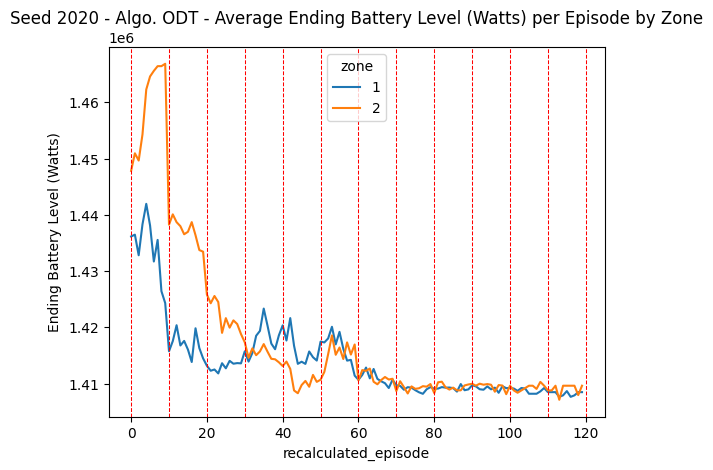

<Figure size 800x600 with 0 Axes>

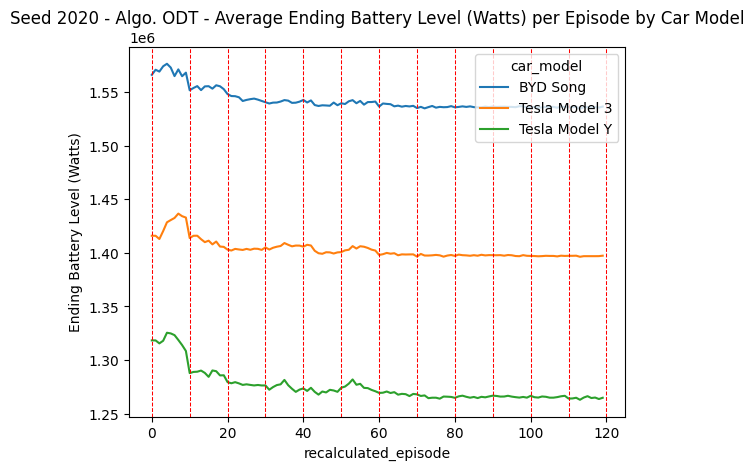

<Figure size 800x600 with 0 Axes>

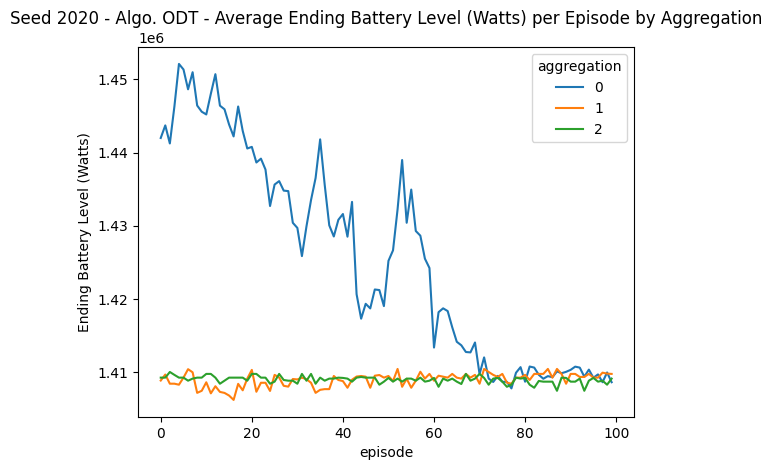

In [8]:
### Ending Battery Metrics
evaluate_by_agent(agent_data, 'ending_battery', 'Ending Battery Level (Watts)', seed, verbose, nn_c['num_episodes'], algorithm_dm)

### Time Spent Travelling Metrics

Evaluating Time Spent Travelling (Steps) Metrics for seed 2020


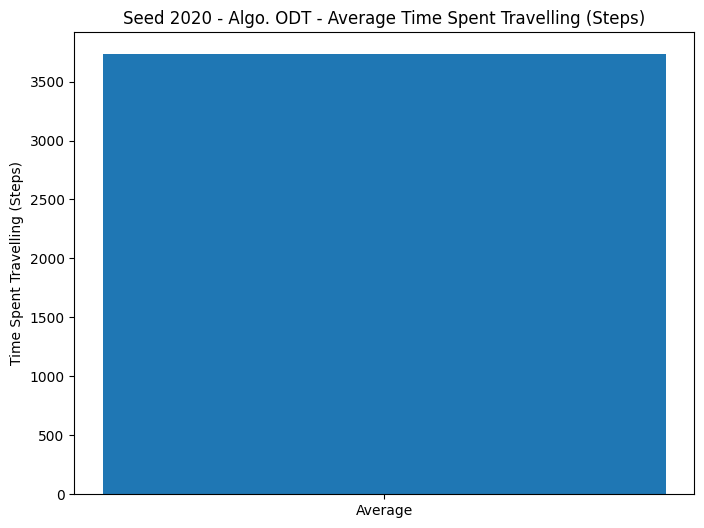

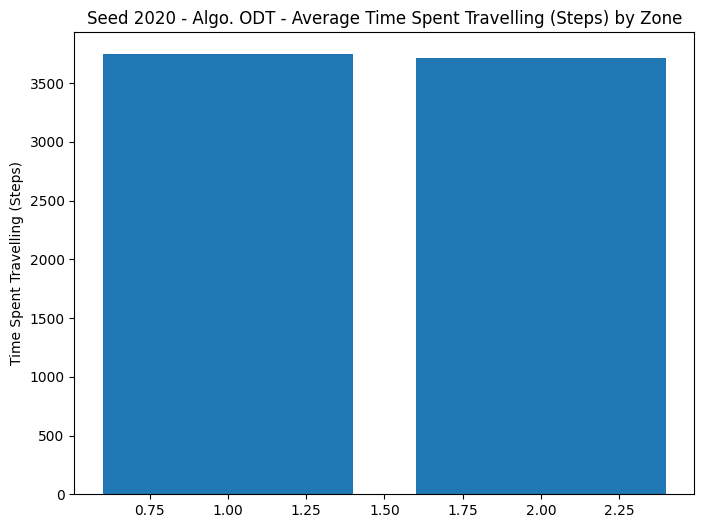

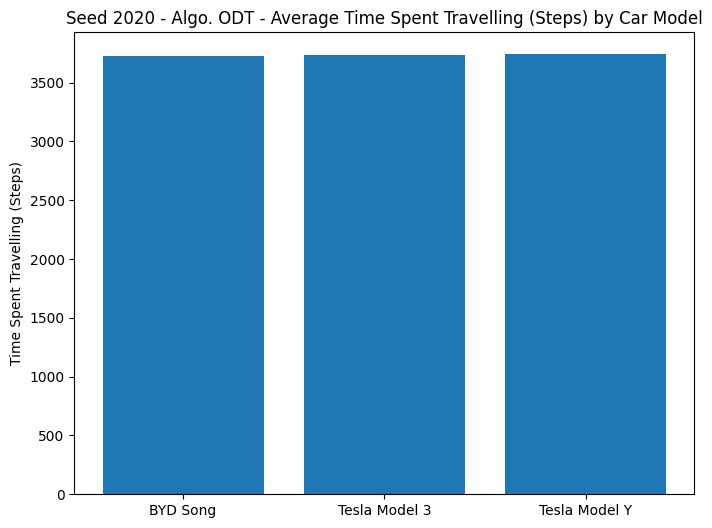

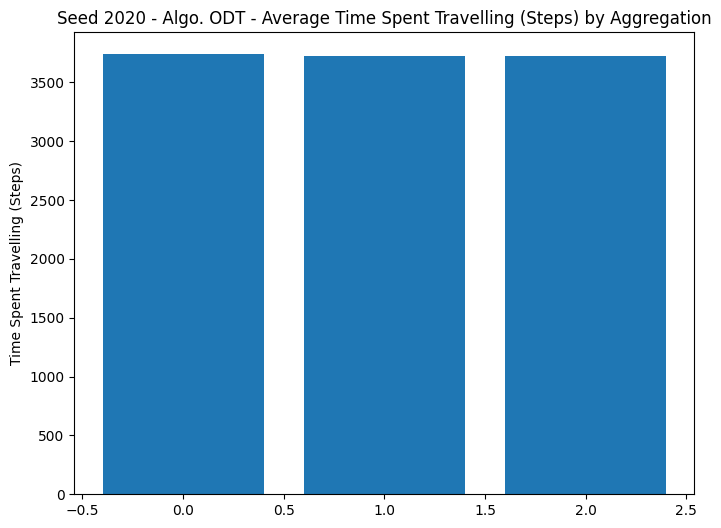

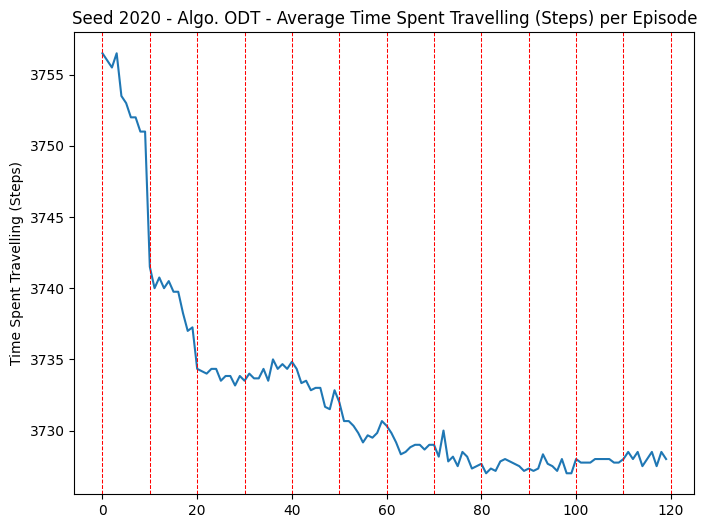

<Figure size 800x600 with 0 Axes>

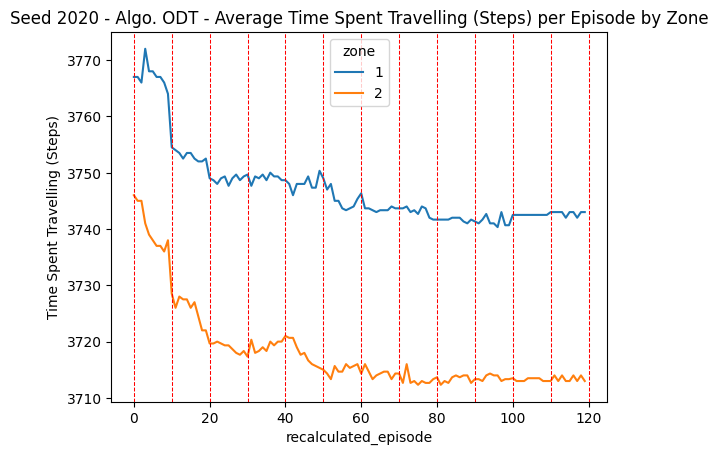

<Figure size 800x600 with 0 Axes>

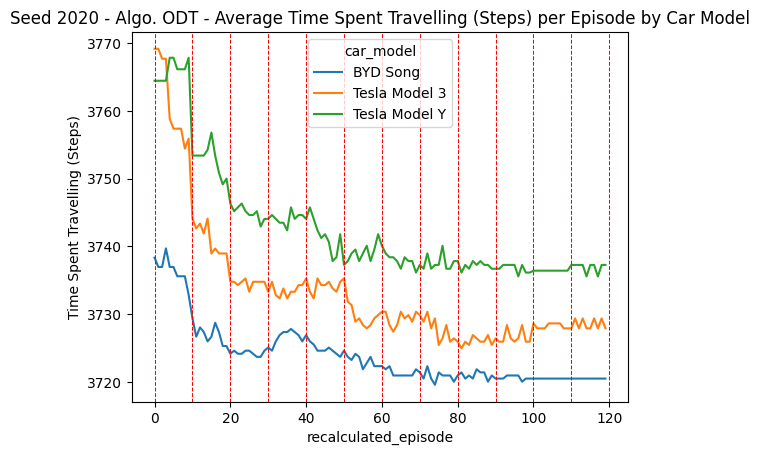

<Figure size 800x600 with 0 Axes>

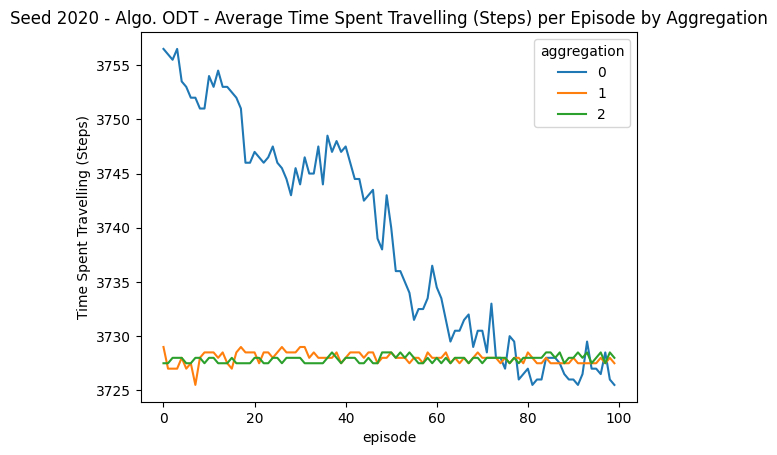

In [9]:
### Time Spent Travelling Metrics
evaluate_by_agent(agent_data, 'duration', 'Time Spent Travelling (Steps)', seed, verbose, nn_c['num_episodes'], algorithm_dm)

### Reward Metrics

Evaluating Simulation Reward Metrics for seed 2020


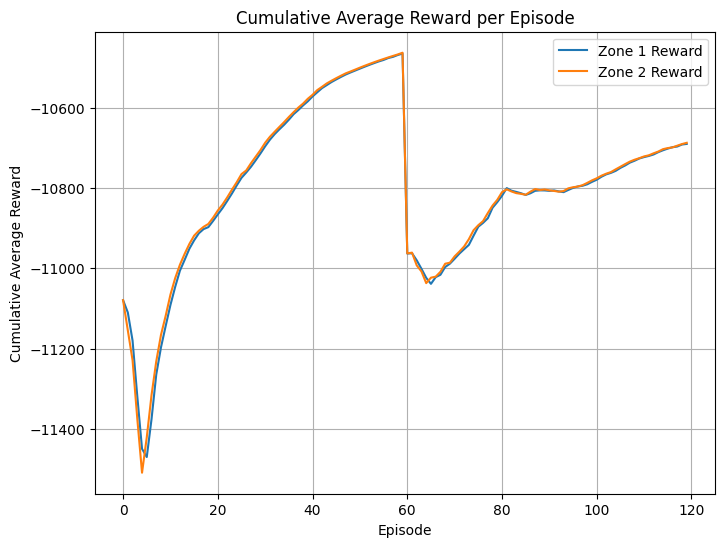

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


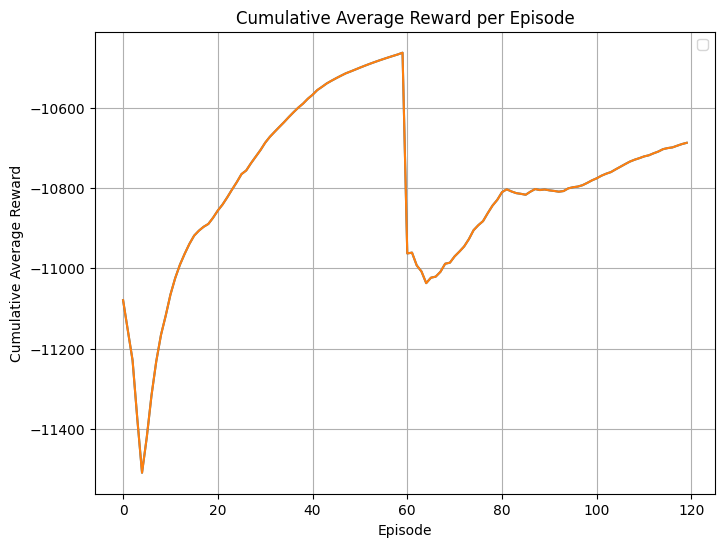

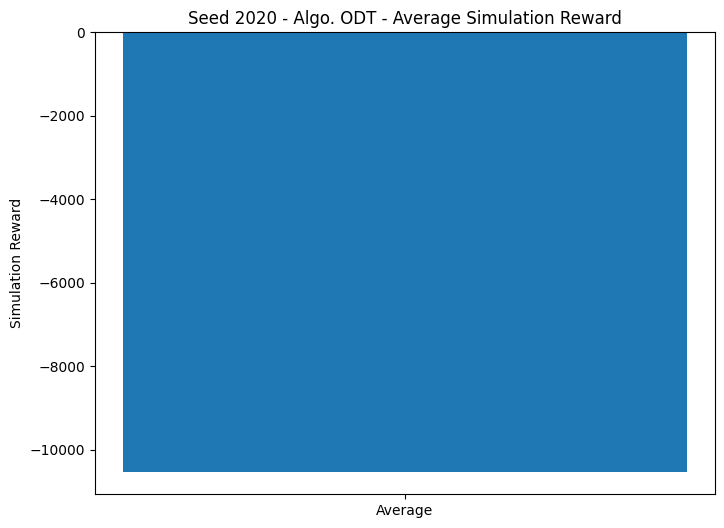

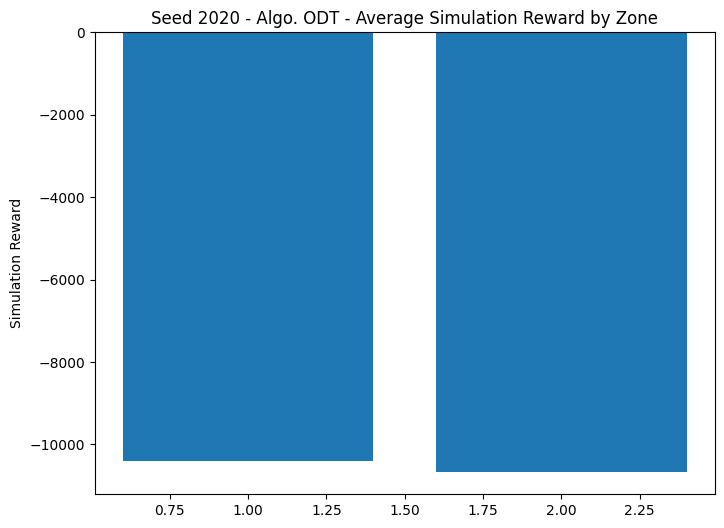

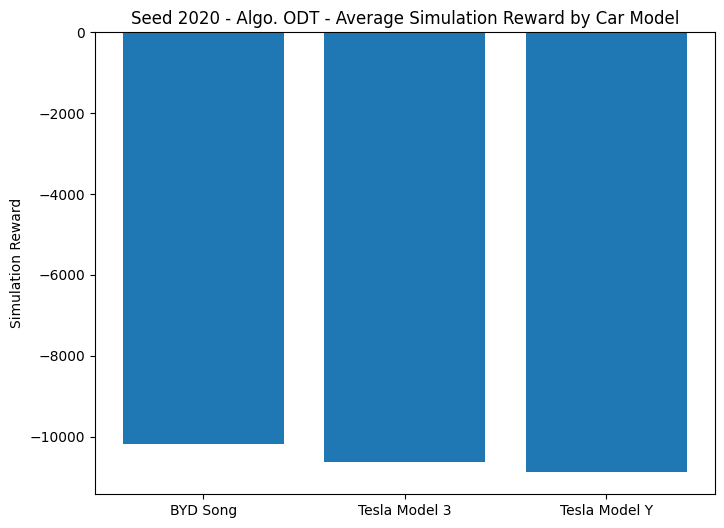

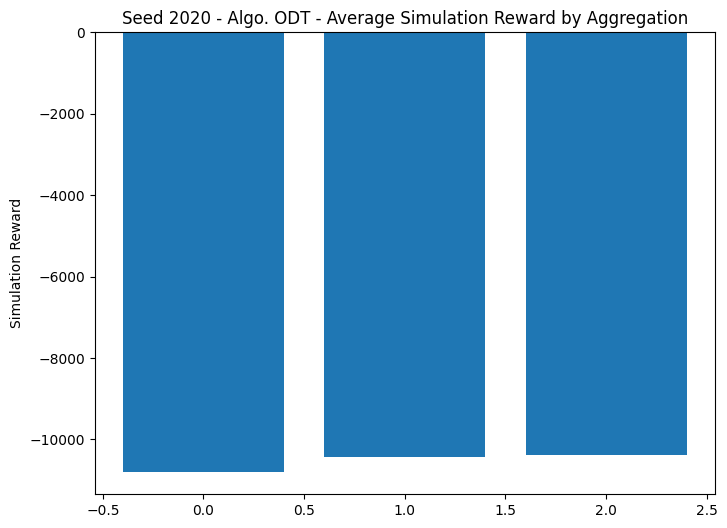

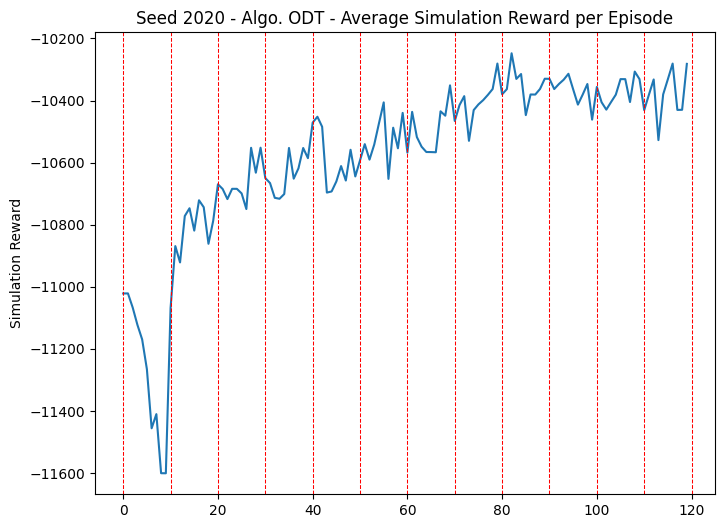

<Figure size 800x600 with 0 Axes>

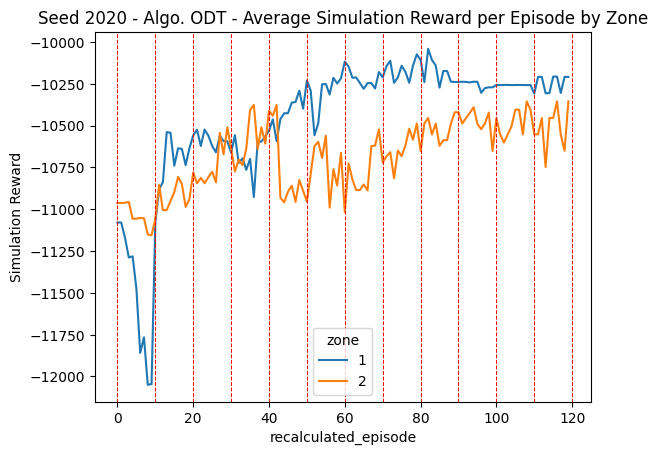

<Figure size 800x600 with 0 Axes>

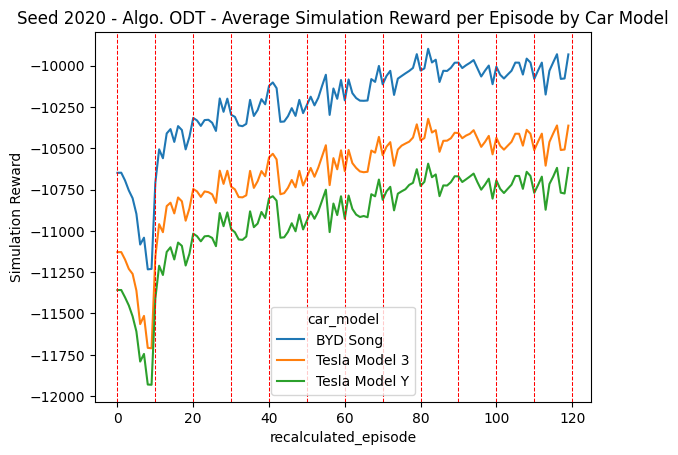

<Figure size 800x600 with 0 Axes>

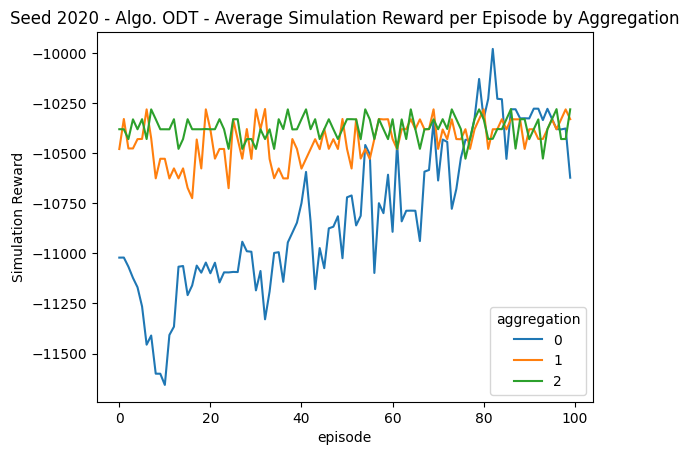

In [13]:
evaluate_by_agent(agent_data, 'reward', 'Simulation Reward', seed, verbose, nn_c['num_episodes'], algorithm_dm)

### Traffic Metrics

Evaluating Traffic Metrics


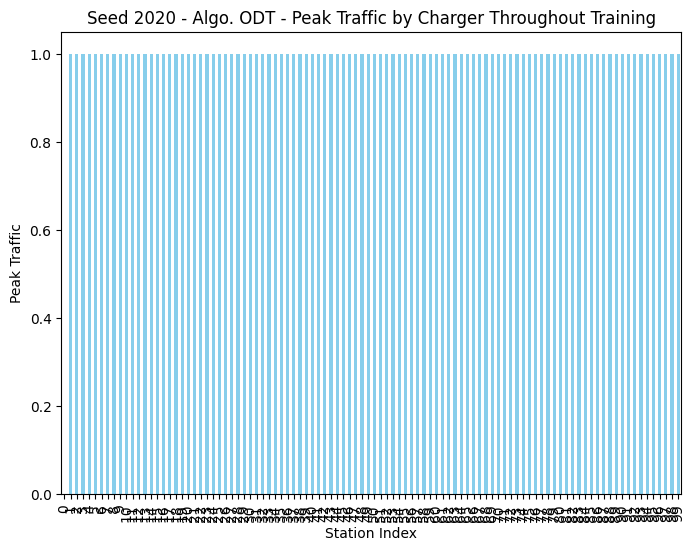

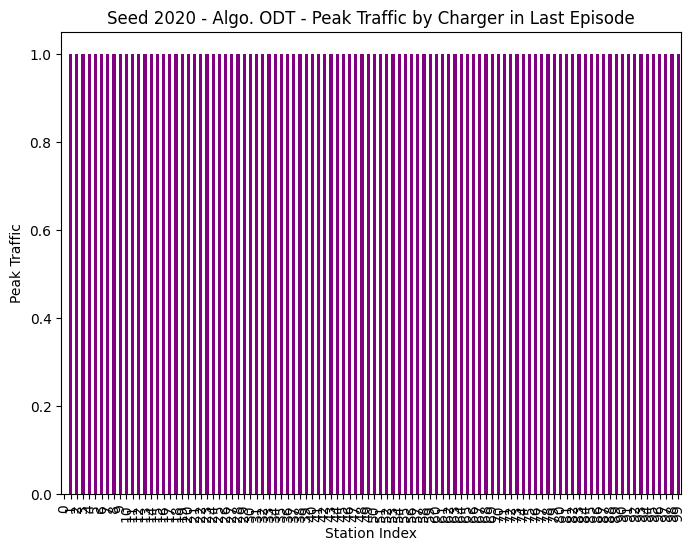

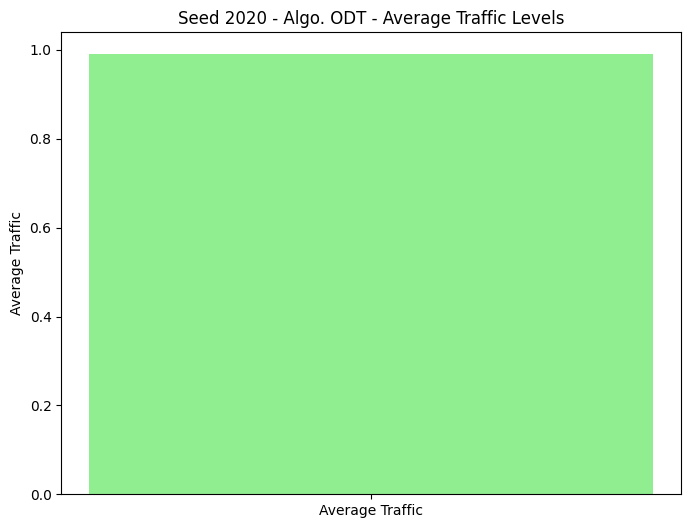

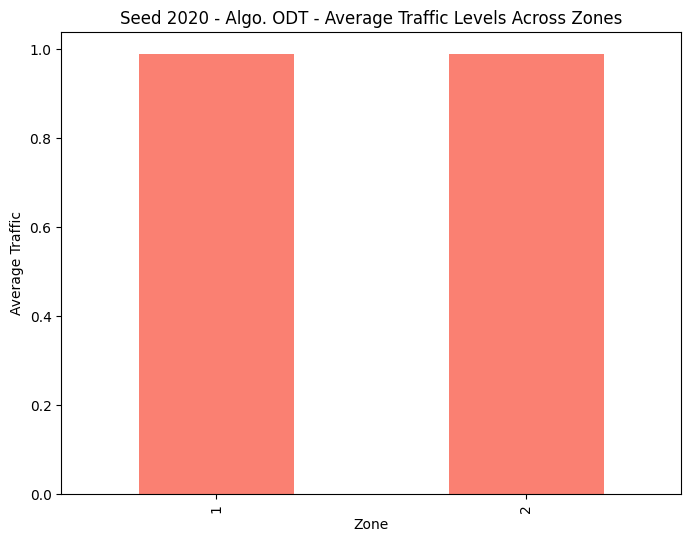

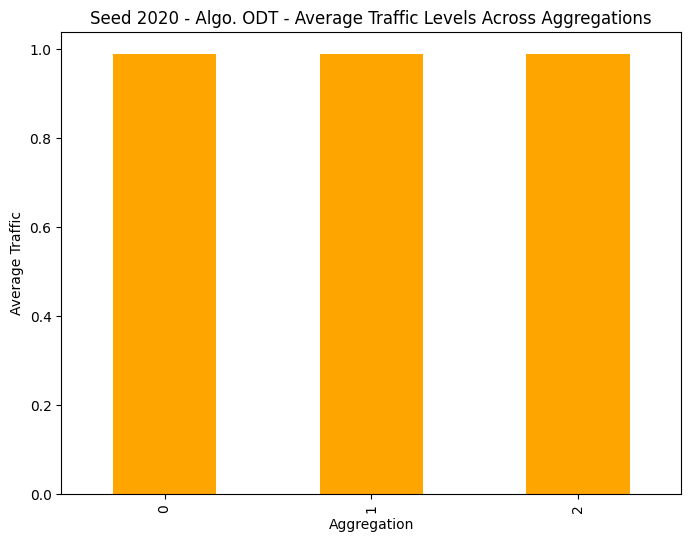

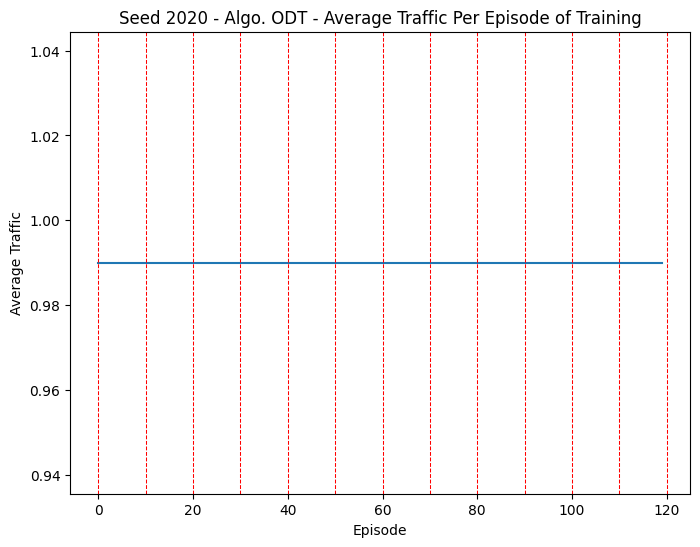

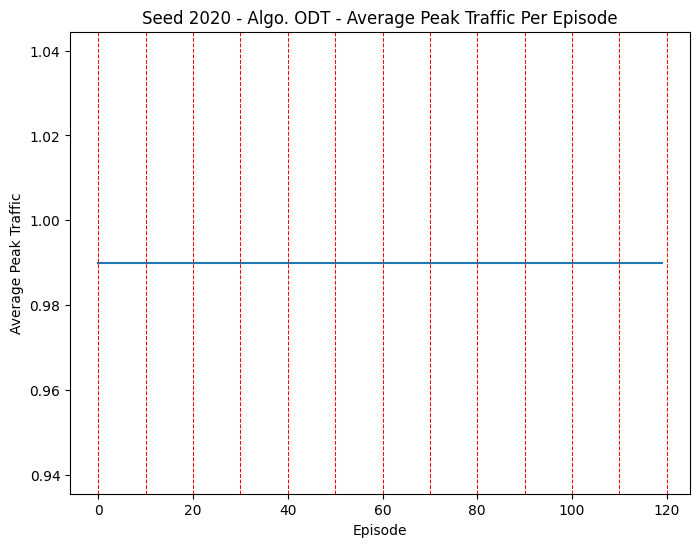

<Figure size 800x600 with 0 Axes>

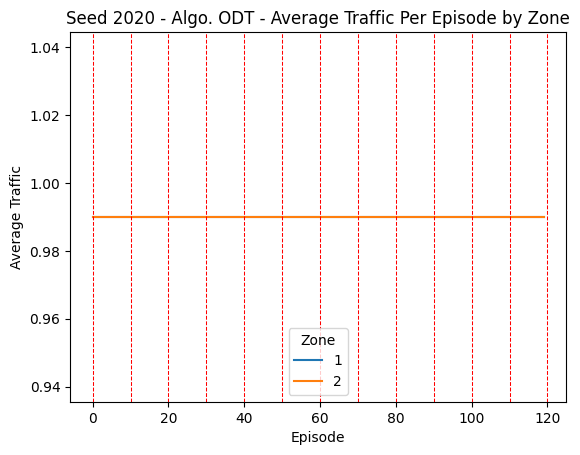

<Figure size 800x600 with 0 Axes>

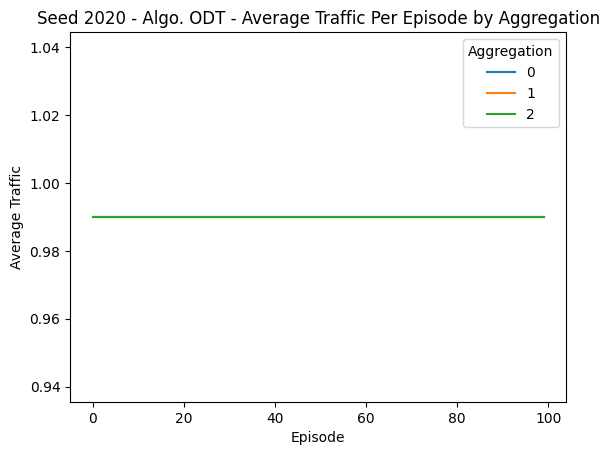

In [11]:
### Traffic Metrics
evaluate_by_station(station_data, seed, verbose, nn_c['num_episodes'], algorithm_dm)

### Training Duration Metrics

In [14]:
# Sum the time it takes for each episode to train to get the total training time
unique_episodes_zones = agent_data.drop_duplicates(subset=['episode', 'timestep', 'aggregation', 'zone'])
total_time_to_train = unique_episodes_zones['timestep_real_world_time'].sum() / unique_episodes_zones['zone'].nunique()

# Output the total time to train and the number of episodes and aggregations
print(f"Total time to train: {total_time_to_train}")
print(f"Number of episodes: {nn_c['num_episodes']}")
print(f"Number of aggregations: {federated_c['aggregation_count']}")
print(f"Average time per episode: {total_time_to_train / (nn_c['num_episodes'] * federated_c['aggregation_count'])}")

#evaluate_by_agent(agent_data, 'timestep_real_world_time', 'Duration Training', seed, verbose, nn_c['num_episodes'], algorithm_dm)

Total time to train: 3924.647394657135
Number of episodes: 10
Number of aggregations: 3
Average time per episode: 130.8215798219045
